<img src="../../shared/img/banner.svg" width=2560></img>

# Bayesian Inference 03 - Flexibility of Bayesian Inference

In [1]:
%matplotlib inline

In [2]:
import sys

sys.path.append("../../")

from shared.src import quiet
from shared.src import seed
from shared.src import style

In [224]:
from pathlib import Path
import random

import daft
from IPython.display import HTML, Image
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import seaborn as sns
import scipy.stats

In [4]:
sns.set_context("notebook", font_scale=1.7)

In [5]:
import shared.src.utils.util as shared_util

In [75]:
def plot_raw_data_sentiment(data, ax):

    ax.scatter(data["album_release_date"], data["positive"],
               alpha=0.1, s=144, color="k");
    ax.set_xlabel("Album Release Date")
    ax.set_ylabel("Positive Sentiment About\nTrump in Hip-Hop Lyric")

In [221]:
def plot_switchpoint(p1, p2, switch, xs, ax, **plot_kwargs):
    ps = np.where(np.array(xs) < switch, p1, p2)
    ax.plot(xs, ps, **plot_kwargs)

# Once You've Learned to Specify Models, Inference Becomes Easy

In the traditional approach,
each change to the model requires a new statistical test
or the verification/extension of an old one.

In the Bayesian Monte Carlo approach,
each change to a model either requires just changing what we do with our samples
or changing our model specification.

Within the context of our difference-in-mean problem,
that means that all of the questions below
become difficult to answer,
essentially requiring a trip back to the blackboard or Wikipedia.

Can I use the standard $t$-test if...

- ...my standard deviations are not the same?

Yes, the test will still perform well, but only if the groups have roughly the same number of observations.
Otherwise, you must use [Welch's modified $t$ test](https://en.wikipedia.org/wiki/Welch%27s_t-test),
or `scipy.stats.ttest_ind` with argument `equal_var=False`.

- ...the groups have different sizes?

Yes, but only if the groups have roughly the same standard deviation. See above.

- ...my likelihood changes from `Normal`?

Yes, [so long as your sample size is large enough](https://thestatsgeek.com/2013/09/28/the-t-test-and-robustness-to-non-normality/). How large is large enough? That's another hard question.

- ...I care about differences in medians?

Yes, if the likelihood is symmetric, because the mean is then the same as the median.
If the mean and median are different,
which is likely why you're interested in the median rather than the mean, then you need a new test,
the [Mann-Whitney $U$ test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test#Comparison_to_Student's_t-test)

And all of that is while still assuming we are working with comparing the "center value" of just two groups in terms of a single measurement!

## All of these questions have simple answers in the Bayesian approach:

What do I do if...

- ...my standard deviations are not the same?

Include that in your model! Just make sure there's a different standard deviation variable for each group,
as in some of the example from the other set of slides.

- ...the groups have different sizes?

Include that in your model!
pyMC will automatically handle combining estimates from each group,
if the standard deviations are pooled, or separately inferring the values, if they are not.

- ...my likelihood changes from `Normal`?

Include that in your model! Just switch the likelihood component and possibly redefine some of the hidden parameter variables.

- ...I care about differences in medians?

Include that in your model! Add a `pm.Deterministic` for calculating that value, or just calculate it afterwards!

## The secret is putting modeling first and statistics second 

All of these questions are about how the model behaves when its assumptions are violated.

When you just call a function like `scipy.stats.ttest_ind`,
it's unclear what model is being used, what its assumptions are,
and how to change that model when those assumptions are violated.

When you write out a pyMC model, all of the assumptions are right there, in the program you have written,
and can be changed on the fly, as can the statistic you calculate.

If you want to see what happens when the model is wrong,
you can simulate data from the alternate model and see how your model behaves.

# This Flexibility Pays Major Dividends when Specifying Models

Rather than sticking only to the "off-the-shelf" models we've carefully studied and reviewed in a statistics course,
we can build them from scratch to answer the exact question we are interested in.

## Example: Donald Trump and Hip-Hop

Throughout the 90s,
Donald Trump's name appeared repeatedly in hip-hop lyrics,
especially by East Coast rappers,
where his name was synonymous with wealth and status.

Trump's rise to the presidency has changed how many people feel about him.
Can we quantify when and to what degree this occurred in hip-hop?

Data collection by [fivethirtyeight](https://fivethirtyeight.com),
downloaded from
[kaggle](https://www.kaggle.com/fivethirtyeight/fivethirtyeight-hip-hop-candidate-lyrics-dataset),
see [this fivethirtyeight post](https://projects.fivethirtyeight.com/clinton-trump-hip-hop-lyrics/)
for more.

Note: the model used here is inspired by two examples in _Bayesian Methods for Hackers_:
1. The "texting switchpoint" example, from [Chapter 1](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb).
2. The "Challenger O-Ring" example, from [Chapter 2](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC3.ipynb).

In [44]:
data_folder = Path(".") / "data"

trump_data = pd.read_csv(data_folder / "trump_hiphop_sentiment_data.csv", index_col=0)

print(trump_data.sample(10))

      id     candidate sentiment  album_release_date
172  174  Donald Trump  positive                1989
368  370  Donald Trump  negative                2016
193  195  Donald Trump  negative                2009
325  327  Donald Trump   neutral                2015
120  122  Donald Trump  positive                2013
174  176  Donald Trump  positive                2006
210  212  Donald Trump   neutral                2013
226  228  Donald Trump  positive                2011
247  249  Donald Trump  positive                1994
263  265  Donald Trump   neutral                2013


Let's eliminate the "neutral" category
and treat sentiment as binary: `"positive"` (`1`) or `"negative"` (`0`)

In [71]:
def sentiment_to_posneg(sentiment):
    if sentiment == "negative":
        return 0
    elif sentiment == "positive":
        return 1
    else:
        return np.nan

trump_data["positive"] = trump_data["sentiment"].apply(sentiment_to_posneg)

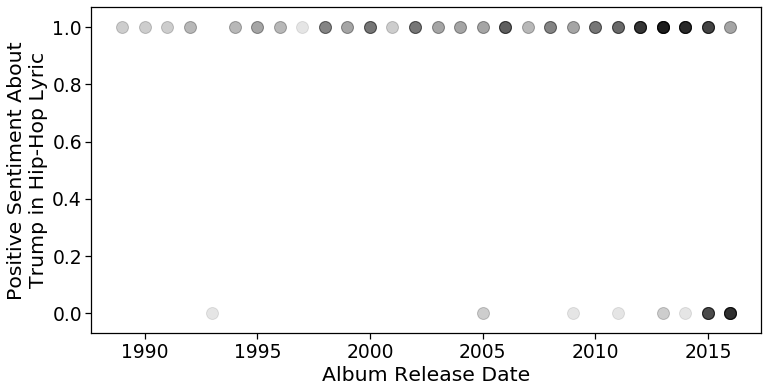

In [76]:
f, ax = plt.subplots(figsize=(12, 6))
plot_raw_data_sentiment(trump_data, ax)

Darker circles mean more lyrics with that sentiment were observed in that year.

### Switchpoint Model

For each observation (pair of year and sentiment), there is some unknown chance $p$ that it was positive.

One reasonable model for this data is that the chance $p$ switched, one year,
from being high to low.

So our model will have three latent, or hidden, variables
that give rise to the unknown variable $p$:

- Chance of positive sentiment before switch, `p_1` / $p_1$
- Chance of positive sentiment after swith, `p_2` / $p_2$
- Time that switch occurred, `switchpoint` / $s$

The resulting model looks like this:

In [151]:
def make_switchpoint_model():
    scale = 2
    p1 = daft.Node("$p_1$", "$p_1$", x=3, y=5.25, scale=scale)
    p2 = daft.Node("$p_2$", "$p_2$", x=5, y=5.25, scale=scale)
    s = daft.Node("$s$", "$s$", x=1.5, y=4, scale=scale)
    p = daft.Node("$p$", "$p$", x=3.5, y=3, scale=scale)
    obs = daft.Node("obs", "obs", x=3.5, y=0.75, observed=True, scale=scale)
    
    plate = daft.Plate((2.5, 0.15, 2, 3.5),label="$N$")

    nodes = [p1, p2, s, p, obs]
    edges = [("$p_1$", "$p$"), ("$p_2$", "$p$"), ("$s$", "$p$"), ("$p$", "obs")]

    pgm = daft.PGM((6, 6))
    [pgm.add_node(node) for node in nodes]
    [pgm.add_edge(*edge, lw=3, head_width=0.3) for edge in edges]
    
    pgm.add_plate(plate)
    pgm.render();

Or, as a graphical model:

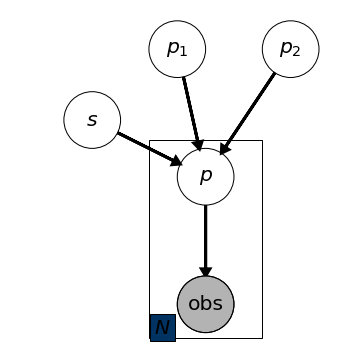

In [152]:
make_switchpoint_model()

#### What are some reasonable priors for these variables?

- $p_1$/$p_2$: unknown number between 0 and 1.
- $s$: unknown integer between 1989 and 2016

If we want to express no strong prior beliefs,
we might say `Uniform` for the $p_i$ and
`DiscreteUniform` for $s$.

#### What is our likelihood?
- obs: whether sentiment in a lyric was positive or negative 

It's a binary variable, so it's a `Bernoulli` likelihood,
with $p$ set by `pm.math.switch`ing between $p_1$ and $p_2$ depending on the date.

#### What is our statistic of interest?

For one, the parameter $s$, which determines when the change happened.
If this value has a wide posterior, then
the change was either gradual or small/

For another,
the difference between $p_2$ and $p_1$,
which captures whether the change was positive or negative and to what degree.
If $p_2 - p_1$ is small in magnitude, or has equal chance of being positive or negative,
then the change was minimal or nonexistent.

In [217]:
trump_data_sub = trump_data.dropna()  # remove all the na values before passing to pyMC
dates = trump_data_sub["album_release_date"]
positive = trump_data_sub["positive"]

with pm.Model() as sentiment_switch_model:
    p1 = pm.Uniform("$p_1$", lower=0, upper=1)  # prior
    p2 = pm.Uniform("$p_2$", lower=0, upper=1)  # prior
    switchpoint = pm.DiscreteUniform(        # prior
        "switchpoint", lower=min(dates), upper=max(dates))  
    
    p = pm.math.switch(shared_util.to_pymc(dates) >= switchpoint, p2, p1)
    
    # likelihood
    positive_sentiment = pm.Bernoulli("positive_sentiment", p, observed=positive)
    
    # statistic / observation of interest
    change_in_sentiment = pm.Deterministic("$p_2 - p_1$", var=p2 - p1)

In [218]:
with sentiment_switch_model:
    sentiment_trace = pm.sample(draws=2500, target_accept=0.9, chains=4)

Sampling 4 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1294.69draws/s]


Above, draw samples and save them as a trace, then put them into a dataframe, below.

In [219]:
switchpoint_samples = shared_util.samples_to_dataframe(sentiment_trace)

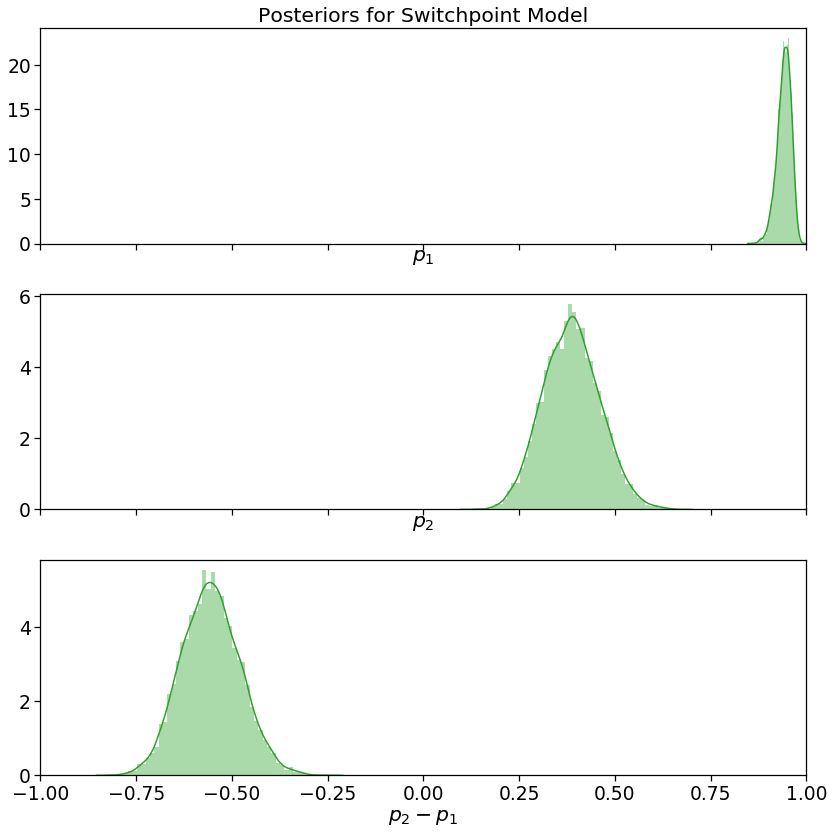

In [220]:
f, axs = plt.subplots(figsize=(12, 12), nrows=3, sharex=True)
sns.distplot(switchpoint_samples["$p_1$"], ax=axs[0], color="C2");
sns.distplot(switchpoint_samples["$p_2$"], ax=axs[1], color="C2");
sns.distplot(switchpoint_samples["$p_2 - p_1$"], ax=axs[2], color="C2");
axs[-1].set_xlim([-1, 1]); axs[0].set_title("Posteriors for Switchpoint Model"); plt.tight_layout();

Looking at the posterior, it seems that sentiment most likely dropped between before and after the switchpoint,
from about 90% positive to about 30% positive.

The total drop was about 60%, but could be as low as 30% or as high as 70%.
Most of the uncertainty comes from the value after the switchpoint:
the posterior for $p_2$ is much wider.

Our posterior for the time of the switch is very tight: it almost certainly happened in 2015.

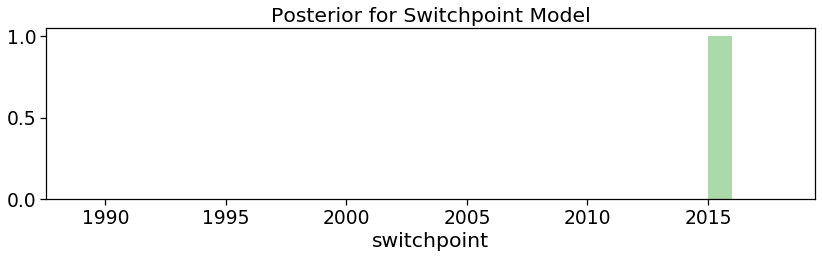

In [213]:
f, ax = plt.subplots(figsize=(12, 4))
sns.distplot(switchpoint_samples["switchpoint"], kde=False, norm_hist=True, bins=range(1989, 2019),
             color="C2");
ax.set_title("Posterior for Switchpoint Model"); plt.tight_layout();

### For simplicity, could use `plot_posterior` instead

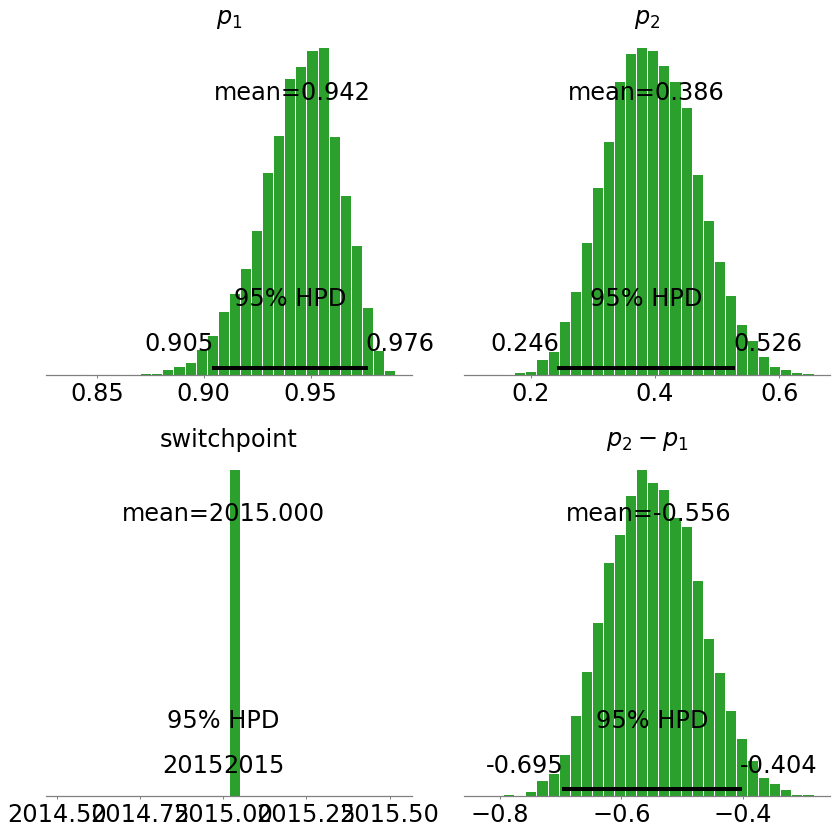

In [216]:
pm.plot_posterior(sentiment_trace, figsize=(12, 12),
                  varnames=["$p_1$", "$p_2$", "switchpoint",  "$p_2 - p_1$"],
                  text_size=24, color="C2");

### But don't be afraid to make a special visualization for your model!

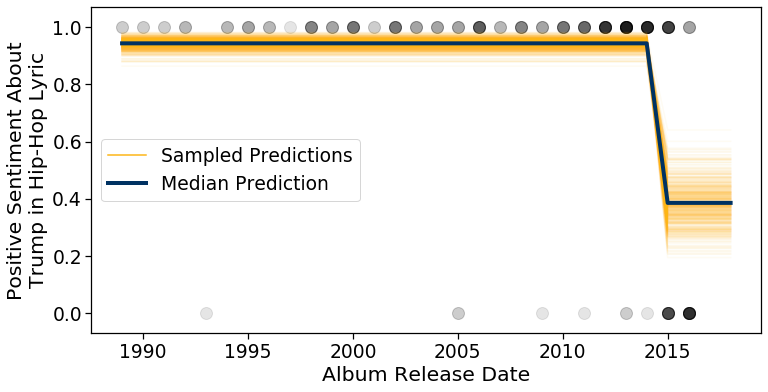

In [227]:
f, ax = plt.subplots(figsize=(12, 6))
plot_raw_data_sentiment(trump_data_sub, ax)

# plot median value for each prediction
plot_switchpoint(switchpoint_samples["$p_1$"].median(),
                 switchpoint_samples["$p_2$"].median(),
                 switchpoint_samples["switchpoint"].median(),
                 range(1989, 2019), ax, lw=4, color="C0", zorder=4);

# plot each sample
for _, sample in switchpoint_samples.sample(frac=0.05).iterrows():
    plot_switchpoint(sample["$p_1$"], sample["$p_2$"], sample["switchpoint"],
                    range(1989, 2019), ax, alpha=0.05, color="C1");
    
ax.legend(
[matplotlib.lines.Line2D([], [], color="C1"),
 matplotlib.lines.Line2D([], [], color="C0", lw=4)],
["Sampled Predictions", "Median Prediction"]);

The median of each parameter is used to select a single model to plot, labeled the "Median Prediction".

The prediction of each sample in the posterior is plotted transparently over the median prediction.
Where the color is darker, more samples were making approximately the same prediction,
whereas where it is lighter, fewer samples were making that prediction.

The median and the mean across samples are not always good choices for single parameters,
but here they seem to fall in a region of high posterior value:
a place where the color is dark in the plot above.

Rather than just viewing the posteriors of the parameters,
it's good to compare the predictions directly to the data,
in some way that makes visually apparent where there's high and low uncertainty.

The fact that all of the samples change heights in 2015 indicates
that there's essentially no uncertainty in the switchpoint,
while the fact that the samples are very spread out afterwards
indicates that 

# Don't Forget About This Flexibility When Modeling

For the next few weeks, we'll focus on models that are Bayesian versions of traditional models:
- ANOVA
- Linear Regression
- Logistic Regression



These models are ubiquitous not only because they are amenable to traditional analysis,
but also because they are the first tool even very sophisticated statisticians reach for
when modeling new data.

We'll still have more freedom because of our approach, especially when writing down our likelihoods,
but don't forget that, if you can formulate a model for your data that doesn't fit into one of the "cookie-cutter" models,
you can always just use that model directly!